<img href="https://colab.research.google.com/github/byM1902/ViT_visualization/blob/master/ViT_embedding_visualization.ipynb" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# If you run this notebook in google colab. You should mount driver first
from google.colab import drive
import os

drive.mount('/content/gdriver')
os.chdir('gdriver/MyDrive/Colab Notebooks/ViT_visualization') # You should change this directory to the folder you saved ViT_visualization folder

# <font color="blue">Load model and data</font>

In [2]:
!pip install ml_collections

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.9 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=171efd743583ead2da25e8b8f9a8af373344163475fe6d103bea2d6884ac7de5
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections


In [5]:
import typing
import io
import os
import numpy as np
import torch
from urllib.request import urlretrieve
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler
from models.modeling_VA import VisionTransformer, CONFIGS
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import xml.etree.ElementTree as ET
import json
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [6]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [7]:
!mkdir -p weights
!wget -O weights/ViT-B_16-224.npz /tmp/Ubuntu.iso https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz

/tmp/Ubuntu.iso: Scheme missing.
--2022-05-26 08:32:40--  https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346335542 (330M) [application/octet-stream]
Saving to: ‘weights/ViT-B_16-224.npz’

weights/ViT-B_16-22 100%[===================>] 330.29M  44.7MB/s    in 7.9s    

2022-05-26 08:32:48 (41.9 MB/s) - ‘weights/ViT-B_16-224.npz’ saved [346335542/346335542]

FINISHED --2022-05-26 08:32:48--
Total wall clock time: 10s
Downloaded: 1 files, 330M in 7.9s (41.9 MB/s)


In [8]:
# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("weights/ViT-B_16-224.npz"))
model = model.eval()

In [9]:
backbone_cnn = model._modules['transformer'].embeddings

# <font color="blue">An example of mask in Pascal dataset</font>
Please download the data at [Pascal VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar)

Extract the dataset and save to **../../datasets**

Raw mask


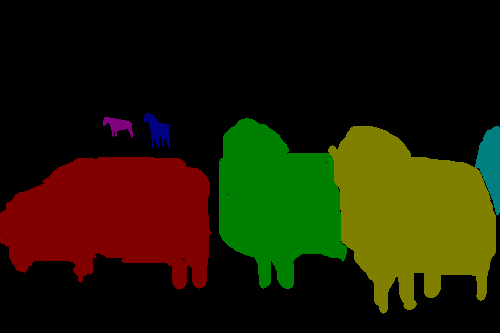

In [ ]:
img = Image.open("../../datasets/VOCdevkit/VOC2009/SegmentationObject/2007_006944.png")
i_r = np.asarray(img)
i_r[i_r > 100] = 0
i_r = Image.fromarray(i_r).quantize(palette=img)
# i_r.save("ref.png")
print("Raw mask")
i_r

Mask after remove small object


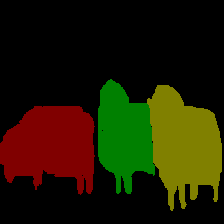

In [ ]:
img = img.resize((224,224))
img_numpy = np.asarray(img).reshape(-1)
mask_selected = img_numpy.copy()
mask_selected[mask_selected > 100] = 0
num_object = len(np.unique(img_numpy))-2
for idx in range(num_object):
    idx_object = np.argwhere(img_numpy == idx+1).reshape(-1)
    if len(idx_object)<=0.14*0.14*224*224:
        mask_selected[idx_object] = 0
mask_selected = mask_selected.reshape([224,224])

ma = Image.fromarray(mask_selected).quantize(palette=img)
print("Mask after remove small object")
ma


Divide an mask into patches


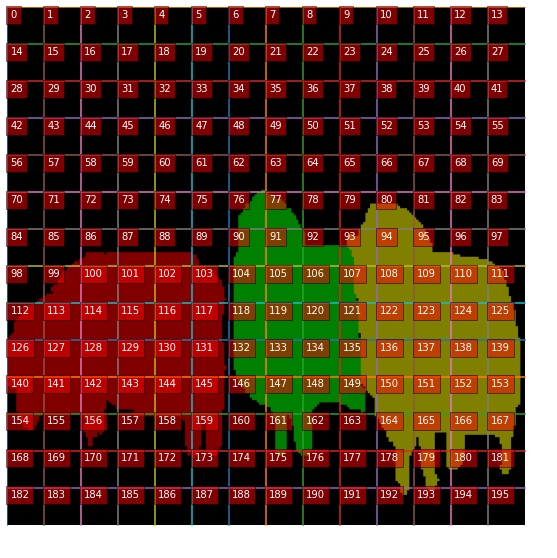

In [ ]:
print("Divide an mask into patches")
plt.figure(figsize=(10, 10))
# img_sort = 2007_003189
ratio_size = 4
size_img = 224*ratio_size
plt.imshow(ma.resize((size_img,size_img)))
ax = plt.gca()
for i in range(14):
    ax.plot([i*16*ratio_size, i*16*ratio_size], [0, size_img])
    for j in range(14):
        if i == 0:
            ax.plot([0, size_img], [j*16*ratio_size, j*16*ratio_size])
        text_x, text_y = i*16*ratio_size+5, j*16*ratio_size+18
        ax.text(text_x, text_y, j*14+i, c='w', bbox=dict(facecolor='red', alpha=0.5), fontsize=10)
plt.axis('off')
plt.savefig('sample.png')
plt.show()


# <font color="blue">Loading Pascal dataset</font>

In [ ]:
class VOC_dataset(Dataset):
    def __init__(self, img_dir, segment_dir, anno_dir, shuffle_grid=None, occlusion_mode=0, occlusion_ratio=1):
        
        self.img_dir = img_dir
        self.segment_dir = segment_dir
        self.anno_dir = anno_dir
        self.shuffle_grid = shuffle_grid
        self.occlusion_mode = occlusion_mode
        self.occlusion_ratio = occlusion_ratio
        # 0 -> none occlusion
        # 1 -> random occlude
        # 2 -> Salient occlusion
        # 3 -> non-salient occlusion
        
        self.max_num_object = 40
        
        img_name_lst = [name.split(".")[0] for name in os.listdir(img_dir)]
        seg_name_lst = [name.split(".")[0] for name in os.listdir(segment_dir)]
        anno_name_lst = [name.split(".")[0] for name in os.listdir(anno_dir)]
        
        self.img_name_lst = list(set(img_name_lst).intersection(seg_name_lst, anno_name_lst))
        
        print("Total number data", len(self.img_name_lst))
        
        self.transformer = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ])
        self.trans_segment = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.img_name_lst)
    
    def _preprocess_im(self, im):
        transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        x = transform(im)
        return x, im

    def _shuffle_img(self, im, grid_size=14, mask_full=None):
        ids = np.arange(grid_size**2)
        np.random.shuffle(ids)
        im = np.array(im)
    #     print(im.shape)
        im_shuf = np.zeros_like(im)
        mask_shuf = np.zeros_like(mask_full)
        h, w = im.shape[:2]
        w_scale = w//grid_size
        h_scale = h//grid_size
        def _locate_xy(i):
            row_id = int(i//grid_size)
            col_id = i%grid_size
            row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
            col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
            return [row_star, row_end, col_star, col_end]
        for i_target, i_org in enumerate(ids):
            row_star, row_end, col_star, col_end = _locate_xy(i_org)
            row_tar_star, row_tar_end, col_tar_star, col_tar_end = _locate_xy(i_target)

            patch = im[row_star:row_end, col_star:col_end, :].copy()
    #         print(row_star,row_end, col_star,col_end, patch.shape)
            im_shuf[row_tar_star:row_tar_end, col_tar_star:col_tar_end, :] = patch

            patch_mask = mask_full[row_star:row_end, col_star:col_end].copy()
    #         print(row_star,row_end, col_star,col_end, patch_mask.shape)
            mask_shuf[row_tar_star:row_tar_end, col_tar_star:col_tar_end] = patch_mask
        im_shuf = Image.fromarray(im_shuf)
        x_shuf, im_shuf = self._preprocess_im(im_shuf)
        return x_shuf, im_shuf, mask_shuf
    
    def _occlude(self, im, mask, grid_size=14, n_random_ocl=None,
                 is_random=False, is_salient=False, is_non_salient=False):
        ids = np.arange(grid_size**2)
        im_cp = np.array(im)
        mask_cp = np.array(mask)
        mask_all = mask_cp.copy()
        mask_all[mask_all > 200] = 0  # remove uncertain area
        mask_all[mask_all!= 0] = 1  # make all object patch is the same object

        h, w = np.array(im).shape[:2]
        w_scale = w//grid_size
        h_scale = h//grid_size

        object_patch = []
        non_object_patch = []
        for i in range(grid_size):
            for j in range(grid_size):
    #             print(i, j, i*grid_size + j, mask_all[i*h_scale:(i+1)*h_scale, j*w_scale:(j+1)*w_scale].mean())
                if mask_all[i*h_scale:(i+1)*h_scale, j*w_scale:(j+1)*w_scale].mean() > 0.15:
                    object_patch.append(i*grid_size + j)
                else:
                    non_object_patch.append(i*grid_size + j)
        if is_salient:
            num_occ = int(n_random_ocl*len(object_patch))
            np.random.shuffle(object_patch)
            id_patches = object_patch[:num_occ]
        elif is_non_salient:
            num_occ = int(n_random_ocl*len(non_object_patch))
            np.random.shuffle(non_object_patch)
            id_patches = non_object_patch[:num_occ]
        elif is_random:
            id_patches = np.arange(grid_size*grid_size)
            np.random.shuffle(id_patches)
            n_random_ocl = int(len(id_patches)*n_random_ocl)      
            id_patches = id_patches[:n_random_ocl]
        else:
            id_patches = []

        def _locate_xy(i):
            row_id = int(i//grid_size)
            col_id = i%grid_size
            row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
            col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
            return [row_star, row_end, col_star, col_end]

        for i in id_patches:
            row_star, row_end, col_star, col_end = _locate_xy(i)
            im_cp[row_star:row_end, col_star:col_end, :] = 0
            mask_cp[row_star:row_end, col_star:col_end] = 0
        return im_cp, mask_cp

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

        raw_img_name = self.img_name_lst[idx]
#         print("\t", raw_img_name)
        
        anno_link = os.path.join(self.anno_dir, "{}.xml".format(raw_img_name))
        tree = ET.parse(anno_link)
        root = tree.getroot()
        lbs = []
        for item in root.findall('./object'):
            for child in item:
                if child.tag == "name":
                    lbs.append(child.text)

        img_path = os.path.join(self.img_dir, "{}.jpg".format(raw_img_name))
        image = Image.open(img_path)
        image = image.resize((224,224))
        
        segmentation_link = os.path.join(self.segment_dir, "{}.png".format(raw_img_name))
        seg_img = Image.open(segmentation_link)
        seg_img = seg_img.resize((224,224))
        seg_img = np.asarray(seg_img)
        
        if self.shuffle_grid:
            image = image.resize((224,224))
            img_trans, img_shuf, seg_shuf = self._shuffle_img(image, grid_size=self.shuffle_grid, mask_full=seg_img)
            seg_img = seg_shuf
        elif self.occlusion_mode == 1:
            img_oc, seg_oc = self._occlude(image, seg_img, n_random_ocl=self.occlusion_ratio, is_random=True)
            seg_img = seg_oc
            img_oc = Image.fromarray(img_oc)
            img_trans = self.transformer(img_oc)
        elif self.occlusion_mode == 2:
            img_oc, seg_oc = self._occlude(image, seg_img, n_random_ocl=self.occlusion_ratio, is_salient=True)
            seg_img = seg_oc
            img_oc = Image.fromarray(img_oc)
            img_trans = self.transformer(img_oc)
        elif self.occlusion_mode == 3:
            img_oc, seg_oc = self._occlude(image, seg_img, n_random_ocl=self.occlusion_ratio, is_non_salient=True)
            seg_img = seg_oc
            img_oc = Image.fromarray(img_oc)
            img_trans = self.transformer(img_oc)
        else:
            img_trans = self.transformer(image)

            
        return img_trans, seg_img , lbs

In [ ]:
dataset_val = VOC_dataset(img_dir="../../datasets/VOCdevkit/VOC2009/JPEGImages",
                          segment_dir="../../datasets/VOCdevkit/VOC2009/SegmentationObject",
                          anno_dir="../../datasets/VOCdevkit/VOC2009/Annotations",
#                          shuffle_grid=None)  # if not shuffle data
#                          shuffle_grid=2,  # if  shuffle data with grid size 2
#                          occlusion_mode=3, occlusion_ratio=1.0   # if using image occlusion
                         )
data_voc = DataLoader(dataset_val, 1, pin_memory=True, shuffle=True)

Total number data 1499


# <font color="blue">Get result of ViT</font>

In [ ]:
idx_run_data = -1
log = False
num_vlid_data = 0

stats_logits = []
stats_img = []
stats_att_mat = []
stats_hidden_states = []
stats_valid_bb = []
stats_valid_mask = []
stats_valid_labels = []

for img_trans, seg_trans, labels in data_voc:
    idx_run_data += 1
    is_valid_result = True
    bb_keep = []
    label_keep = []
    mask_keep = []
    labels = np.asarray(labels).reshape(-1)

    seg_trans = seg_trans[0].detach().numpy().reshape(-1)
    seg_trans[seg_trans > 200] = 0
    num_object = len(labels)
    if num_object >= 2:
        for idx_object in range(num_object):
            idx_object_token = np.argwhere(seg_trans==idx_object+1).reshape(-1)
            if len(idx_object_token) > 0.14*224*0.14*224:
                mask_object = np.zeros_like(seg_trans).reshape(-1)
                mask_object[idx_object_token] = 1
                mask_keep.append(mask_object)
                label_keep.append(labels[idx_object])
    if len(mask_keep) < 2:
        is_valid_result = False
    if is_valid_result:
        logits, att_mat, hidden_states_layers  = model(img_trans)
        probs = torch.nn.Softmax(dim=-1)(logits)
        top5 = torch.argsort(probs, dim=-1, descending=True)
        if is_valid_result and len(mask_keep) >= 2:
            
            num_vlid_data += 1
            att_mat = torch.stack(att_mat).squeeze(1)
            att_mat = torch.mean(att_mat, dim=1) # [n_layer, n_tokens, n_tokens]=[12, 197, 197]
            # To account for residual connections, we add an identity matrix to the
            # attention matrix and re-normalize the weights.
            residual_att = torch.eye(att_mat.size(1)) # [n_tokens, n_tokens]=[197, 197]
            aug_att_mat = att_mat + residual_att
            aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

            stats_logits.append(logits[0])
            stats_att_mat.append(aug_att_mat)
            stats_hidden_states.append(torch.stack(hidden_states_layers).squeeze(1))
            stats_valid_mask.append(np.stack(mask_keep))
            stats_valid_labels.append(label_keep)
            
            if num_vlid_data < 10:
                stats_img.append(img_trans)
    if idx_run_data % 100 == 0:
        print("idx_run_data:", idx_run_data, "num_vlid_data:", num_vlid_data)
    if idx_run_data > 1000:
        break
print("idx_run_data:", idx_run_data, "num_vlid_data:", num_vlid_data)

idx_run_data: 0 num_vlid_data: 0
idx_run_data: 100 num_vlid_data: 36
idx_run_data: 200 num_vlid_data: 74
idx_run_data: 300 num_vlid_data: 113
idx_run_data: 400 num_vlid_data: 147
idx_run_data: 500 num_vlid_data: 185
idx_run_data: 600 num_vlid_data: 225
idx_run_data: 700 num_vlid_data: 262
idx_run_data: 800 num_vlid_data: 294
idx_run_data: 900 num_vlid_data: 328
idx_run_data: 1000 num_vlid_data: 366
idx_run_data: 1001 num_vlid_data: 367


In [ ]:
stats_hidden_states = torch.stack(stats_hidden_states)
print(stats_hidden_states.size())

stats_att_mat = torch.stack(stats_att_mat)
print(stats_att_mat.size())

torch.Size([367, 12, 197, 768])
torch.Size([367, 12, 197, 197])


# <font color="blue">Cluster embeddings and calculate the measurements</font>

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.optimize import linear_sum_assignment

In [ ]:
print("Maximum number of objects in an image", max([len(l) for l in stats_valid_labels]))

Maximum number of objects in an image 7


In [ ]:
stats_pur_matrix = []
stats_token_in_cluster = []
stats_intracluster = []

stats_rate_uniq_label = []
stats_rate_clus_object = []
stats_silhouette = []


for idx_sample, (hidden_all_layers, mask_all_objects, gt_label) in enumerate(zip(stats_hidden_states, stats_valid_mask, stats_valid_labels)):
    is_invalid_sample = False
    db_scan_cls_labels = []
    rate_uniq_label_layers = []
    rate_clus_object = []
    score_silhouette = []
    mask_to_idx = []
    
    total_mask = []
    gt_label = gt_label
    for idx_object, m in enumerate(mask_all_objects):
        m = m.astype(np.float64).reshape((224,224))
        m_instance = np.zeros((14, 14), dtype=np.float64)
        for i in range(14):
            for j in range(14):
                m_instance[i, j] = m[i*16: (i+1) * 16, j*16: (j+1) * 16].mean()+0.6

        total_mask.append(m_instance.astype(np.int32) * (idx_object + 1))

    total_mask = np.stack(total_mask).sum(0).reshape(-1)
    mask_to_idx = []
    for idx_object in range(len(mask_all_objects)):
        object_idx = np.argwhere(total_mask == idx_object+1).reshape(-1)
        if len(object_idx) <= 2:
            is_invalid_sample = True
        mask_to_idx.append(object_idx)
    none_object_idx = np.argwhere(1-m_instance).reshape(-1)
    all_object_idx = np.concatenate(mask_to_idx)
    
    num_object = len(mask_to_idx)
    pur_matrix_layer = []
    token_in_cluster_layer = []
    intra_layer = []
    if is_invalid_sample:
        continue
    for lvl, hidden_layer_i in enumerate(hidden_all_layers):
        # ignore the cls_token
        hidden_layer_i = hidden_layer_i.detach().numpy()
        dis_eps = []
        len_token = []
        for idx_token_object in mask_to_idx:
            len_token.append(len(idx_token_object))
            dis_eps_obj = (hidden_layer_i[1:][idx_token_object[:-1]] - hidden_layer_i[1:][idx_token_object[1:]])**2
            dis_eps_obj = np.sqrt(dis_eps_obj.sum(-1)).mean()
            dis_eps.append(dis_eps_obj)
        dis_eps = sum(dis_eps)/len(mask_to_idx)
        mean_token = min(len_token)
        db = DBSCAN(eps=dis_eps, min_samples=3).fit(hidden_layer_i[1:][all_object_idx])  # => better => max=0.7
        db_scan_cls_labels.append(db.labels_)
        db_label = np.ones(len(hidden_layer_i[1:]), dtype=int)*-10
        db_label[all_object_idx] = db.labels_
        num_cluster = max(db_label) + 1
        pur_matrix = np.zeros((num_cluster, num_object))
#         print(num_cluster)
        token_in_cluster = []
        intra_cluster = []
        sum_pur = 0
        rate_clus_object.append(num_cluster/num_object)
        dominated_label_cluster = []
        for idx_clus in range(num_cluster):
            idx_in_clus = np.argwhere(db_label == idx_clus).reshape(-1)
#             print(idx_in_clus)
            max_pur = -1
            token_max_pur = None
            dominate_label = -1
            for idx_obj in range(num_object):
                idx_object_token = mask_to_idx[idx_obj]
                inter_index = set(idx_in_clus).intersection(idx_object_token)
                purity = len(inter_index)/len(idx_in_clus)
                pur_matrix[idx_clus, idx_obj] = purity
                if purity > max_pur:
                    max_pur = purity
                    dominate_label = gt_label[idx_obj]
                    token_max_pur = hidden_layer_i[1:][idx_in_clus]
            sum_pur += pur_matrix[idx_clus].max()*(len(idx_in_clus)/sum(len_token))
            dominated_label_cluster.append(dominate_label)
            if len(token_max_pur):
                dis_pairwise = cosine_similarity(token_max_pur)
                iu1 = np.triu_indices(len(token_max_pur), 1)
                intra_cluster.append(dis_pairwise[iu1].mean())
        dominated_label_cluster_rate = len(np.unique(dominated_label_cluster))/len(np.unique(gt_label))
        rate_uniq_label_layers.append(dominated_label_cluster_rate)
        pur_matrix_layer.append(sum_pur)
        if len(intra_cluster) > 0:
            intra_layer.append(sum(intra_cluster)/len(intra_cluster))
        else:
            intra_layer.append(-1)
        if num_cluster == 0:
            score_silhouette.append(-1)
        elif num_cluster == 1:
            score_silhouette.append(0)
        else:
            sample_in_cls = []
            cls_label = []
            for idx_clus in range(num_cluster):
                idx_in_clus = np.argwhere(db_label == idx_clus).reshape(-1)
                sample_in_cls.append(hidden_layer_i[1:][idx_in_clus])
                cls_label.append([idx_clus]*len(idx_in_clus))
            sample_in_cls = np.concatenate(sample_in_cls)
            
            cls_label = np.concatenate(cls_label)
            sc = silhouette_score(sample_in_cls, cls_label, metric='cosine')
            score_silhouette.append(sc)
    stats_pur_matrix.append(pur_matrix_layer)
    stats_intracluster.append(intra_layer)
    stats_rate_uniq_label.append(rate_uniq_label_layers)
    stats_rate_clus_object.append(rate_clus_object)
    stats_silhouette.append(score_silhouette)
    if len(stats_pur_matrix) == 500:
        break

In [ ]:
stats_silhouette = np.asarray(stats_silhouette)
print(stats_silhouette.shape)
stats_pur_matrix = np.asarray(stats_pur_matrix)
print(stats_pur_matrix.shape)
stats_rate_clus_object = np.asarray(stats_rate_clus_object)
print(stats_rate_clus_object.shape)
stats_rate_uniq_label = np.asarray(stats_rate_uniq_label)
print(stats_rate_uniq_label.shape)
stats_intracluster = np.asarray(stats_intracluster)
print(stats_intracluster.shape)

(361, 12)
(361, 12)
(361, 12)
(361, 12)
(361, 12)


In [ ]:
cosine_distance_layer = []
for idx_sample, (hidden_all_layers, mask_all_objects) in enumerate(zip(stats_hidden_states, stats_valid_mask)):
    mask_to_idx = []
    is_invalid_sample = False
    total_mask = []
    for idx_object, m in enumerate(mask_all_objects):
        m = m.astype(np.float64).reshape((224,224))
        m_instance = np.zeros((14, 14), dtype=np.float64)
        for i in range(14):
            for j in range(14):
                m_instance[i, j] = m[i*16: (i+1) * 16, j*16: (j+1) * 16].mean()+0.6

        total_mask.append(m_instance.astype(np.int32) * (idx_object + 1))
    total_mask = np.stack(total_mask).sum(0).reshape(-1)
#     print(total_mask)
    mask_to_idx = []
    for idx_object in range(len(mask_all_objects)):
        object_idx = np.argwhere(total_mask == idx_object+1).reshape(-1)
        if len(object_idx) <= 2:
            is_invalid_sample = True
        mask_to_idx.append(object_idx)
    none_object_idx = np.argwhere(total_mask == 0).reshape(-1)
    all_object_idx = np.concatenate(mask_to_idx)
    
    num_object = len(mask_to_idx)
    pur_matrix_layer = []
    token_in_cluster_layer = []
    intra_layer = []
    if is_invalid_sample:
        continue
    
    cosine_dis_lvl = []
    for hidden_lvl in hidden_all_layers:
        hidden_lvl = hidden_lvl[1:].detach().numpy()
        cosine_mean_object = 0
        for idx_token_object in mask_to_idx:
            token_obj = hidden_lvl[idx_token_object]
            cosine_dis = cosine_similarity(token_obj)
            idx_triu = np.triu_indices(len(token_obj), 1)
            cosine_mean_object += cosine_dis[idx_triu].mean()
        cosine_mean_object = cosine_mean_object/len(mask_all_objects)
        cosine_dis_lvl.append(cosine_mean_object)
    cosine_distance_layer.append(cosine_dis_lvl)

In [ ]:
cosine_distance_layer = np.asarray(cosine_distance_layer)
print(cosine_distance_layer.shape)

(361, 12)


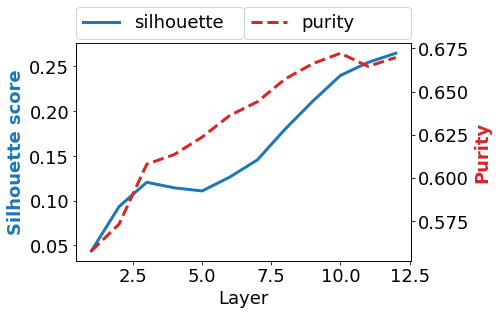

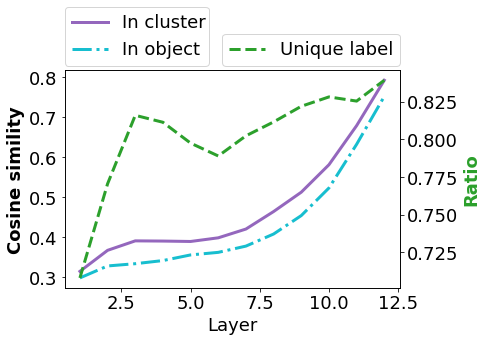

In [ ]:
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=18)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), stats_silhouette.mean(0), label="silhouette", color='tab:blue', linewidth=3)
ax2.plot(np.arange(1, 13), stats_pur_matrix.mean(0), label="purity", color='tab:red', linewidth=3, linestyle="dashed")

ax1.legend(bbox_to_anchor=(0., 1.02, 0.5, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax2.legend(bbox_to_anchor=(0.5, 1.02, 0.5, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax1.set_xlabel('Layer', fontsize=18)
ax1.set_ylabel('Silhouette score', color='tab:blue', fontsize=18, fontweight='bold')
ax2.set_ylabel('Purity', color='tab:red', fontsize=18, fontweight='bold')

# plt.savefig("sil_pur_rate.png", bbox_inches='tight', pad_inches=0)
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), stats_intracluster.mean(0), label="In cluster", color='tab:purple', linewidth=3)
ax1.plot(np.arange(1, 13), cosine_distance_layer.mean(0), label="In object", color='tab:cyan', linewidth=3, linestyle="dashdot")
ax2.plot(np.arange(1, 13), stats_rate_uniq_label.mean(0), label="Unique label", color='tab:green', linewidth=3, linestyle="dashed")

ax1.set_xlabel('Layer', fontsize=18)
ax1.set_ylabel('Cosine simility', color='k', fontsize=18, fontweight='bold')
ax2.set_ylabel('Ratio', color='tab:green', fontsize=18, fontweight='bold')
ax1.legend(bbox_to_anchor=(0., 1.02, 0.43, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax2.legend(bbox_to_anchor=(0.47, 1.02, 0.53, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
# plt.savefig("cosine_uniq_rate.png", bbox_inches='tight', pad_inches=0)
plt.show()

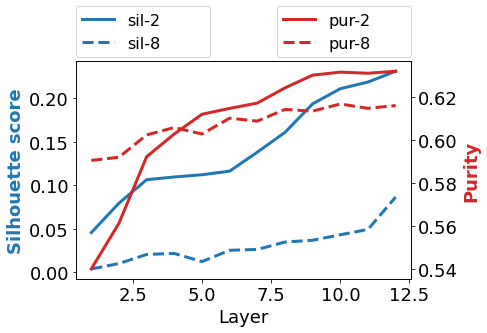

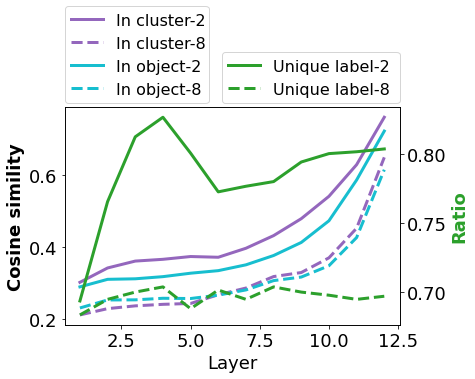

In [ ]:
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=16)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), stats_silhouette_2.mean(0), label="sil-2", color='tab:blue', linewidth=3)
ax1.plot(np.arange(1, 13), stats_silhouette_8.mean(0), label="sil-8", color='tab:blue', linewidth=3, linestyle="dashed")
ax2.plot(np.arange(1, 13), stats_pur_matrix_2.mean(0), label="pur-2", color='tab:red', linewidth=3)
ax2.plot(np.arange(1, 13), stats_pur_matrix_8.mean(0), label="pur-8", color='tab:red', linewidth=3, linestyle="dashed")

ax1.legend(bbox_to_anchor=(0., 1.02, 0.4, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax2.legend(bbox_to_anchor=(0.6, 1.02, 0.4, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
ax1.set_xlabel('Layer', fontsize=18)
ax1.set_ylabel('Silhouette score', color='tab:blue', fontsize=18, fontweight='bold')
ax2.set_ylabel('Purity', color='tab:red', fontsize=18, fontweight='bold')
# ax1.set(xlim=(1, 13))
# ax2.set(xlim=(1, 13))
plt.savefig("sil_pur_rate_28.png", bbox_inches='tight', pad_inches=0)
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), stats_intracluster_2.mean(0), label="In cluster-2", color='tab:purple', linewidth=3)
ax1.plot(np.arange(1, 13), stats_intracluster_8.mean(0), label="In cluster-8", color='tab:purple', linewidth=3, linestyle="dashed")
ax1.plot(np.arange(1, 13), cosine_distance_layer_2.mean(0), label="In object-2", color='tab:cyan', linewidth=3)
ax1.plot(np.arange(1, 13), cosine_distance_layer_8.mean(0), label="In object-8", color='tab:cyan', linewidth=3, linestyle="dashed")
ax2.plot(np.arange(1, 13), stats_rate_uniq_label_2.mean(0), label="Unique label-2", color='tab:green', linewidth=3)
ax2.plot(np.arange(1, 13), stats_rate_uniq_label_8.mean(0), label="Unique label-8", color='tab:green', linewidth=3, linestyle="dashed")

ax1.set_xlabel('Layer', fontsize=18)
ax1.set_ylabel('Cosine simility', color='k', fontsize=18, fontweight='bold')
ax2.set_ylabel('Ratio', color='tab:green', fontsize=18, fontweight='bold')
# bbox_to_anchor=(0., 1.02, 3.5, .102), loc='lower left',
#                       ncol=6, mode="expand", borderaxespad=0., prop={"size":16}
ax1.legend(bbox_to_anchor=(0., 1.02, 0.43, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
# ax1.set(xlim=(1, 13))
# ax1.legend()
ax2.legend(bbox_to_anchor=(0.47, 1.02, 0.53, .102), loc='lower left', ncol=1, mode="expand", borderaxespad=0.)
# ax2.set(xlim=(1, 13))
plt.savefig("cosine_uniq_rate_28.png", bbox_inches='tight', pad_inches=0)

plt.show()

# <font color="blue">Process individual image</font>

In [10]:
# img_url = "https://images.mypetlife.co.kr/content/uploads/2019/04/09192811/welsh-corgi-1581119_960_720.jpg"
# img_url = 'http://www.sydneyolympicpark.com.au/-/media/images/sopa/sydney-olympic-park-site/the-park/community/dogsinthepark-header-image.jpg'
# img_url = 'https://media.jlrms.com/styles/low_res/s3/alf/images/2019-06/14681b51-bc4b-4cff-8168-417d58cc7b52/jagxe300sportsvproject8dna18101806.jpg' # couple car
# img_url = 'https://www.popsci.com/uploads/2020/09/24/BIII6V75B5HJXJEFITGMI5GWAM-1024x768.jpg' # elephant
# img_url = 'https://res.cloudinary.com/jerrick/image/upload/f_jpg,fl_progressive,q_auto,w_1024/609c031f84017b001f224989.jpg'
# img_url = 'https://www.caninecompany.com/getmedia/eb5aa50d-253a-4f69-805f-6dced4349046/splash-1.jpg' # single white dog

# dog_cat
img_url = 'https://i.insider.com/536aa78069bedddb13c60c3a?width=600&format=jpeg&auto=webp'
# 2 elephant
# img_url = 'https://mysteriousofscience.com/wp-content/uploads/2021/06/b-4-590x295.jpg'

#dog and bird big
# img_url = 'https://i.ytimg.com/vi/OBkjD2iAQ6Q/maxresdefault.jpg' # dog bird

# multiple objects
# img_url = [
#     'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02277742_ringlet.JPEG?raw=true',
#     'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01582220_magpie.JPEG?raw=true',
#     'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02403003_ox.JPEG?raw=true',
#     'https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n02749479_assault_rifle.JPEG?raw=true'
# ]

def _preprocess(url):
#   urlretrieve(img_url, "/content/gdriver/MyDrive/ViT_data/attention_data/img.jpg")
    mix = False
    if isinstance(url, list):
        mix = True
    if mix:
        for idx_img, img_link in enumerate(url):
            urlretrieve(img_link, "attention_data/img_{}.jpg".format(idx_img))
    else:
        urlretrieve(url, "attention_data/img.jpg")
    
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    if mix:
        img_numpy = []
        for idx_img, img_link in enumerate(url):
            img_np = np.asarray(Image.open("attention_data/img_{}.jpg".format(idx_img)).resize((224, 224)))
            if img_np.ndim == 2:
                img_np = np.tile(img_np[..., None], [1,1,3])
            img_numpy.append(img_np)
        img_numpy = np.stack(img_numpy)
        img_numpy = img_numpy.reshape([2, 2, 224, 224, 3]).transpose([0, 2, 1, 3, 4])  # [2, 224, 2, 224, 3]
        img_numpy = img_numpy.reshape([2*224, 2*224, 3])
        im = Image.fromarray(img_numpy)
    else:
        im = Image.open("attention_data/img.jpg")
    #   im = Image.open("/content/gdriver/MyDrive/paper_transformer_visualization_VA/ViT-pytorch/attention_data/cat_dog.jpg")
    x = transform(im)
    im = im.resize((224,224))
    return x, im
#     return img_numpy

x, im = _preprocess(img_url)

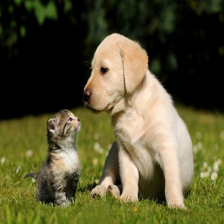

In [11]:
im

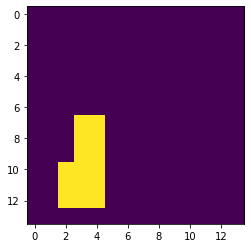

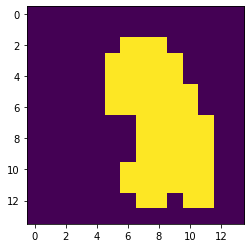

In [12]:
 # dog cat
mask_tempo = [
    [101,102,115,116,129,130,142,144,156,158,170,172],
    [34, 36, 47, 51, 61, 65, 75, 80, 89, 94, 105, 109, 119, 123, 133, 137, 146, 151, 160, 165, 175, 176, 178, 179]
]

#2 elephant
# mask_tempo = [
#     [3,4,6,7,17,21,31,35,44,49,58,63,72, 77, 86, 89,100,103, 114, 117, 128,132, 142, 146, 156,156, 158, 160, 170, 170, 172, 174, 184, 184, 186, 188],
#     [122, 122, 135, 137,149,151,163,165,177,179, 191, 192]
# ]

#dog and bird big
# mask_tempo = [
# #     [30, 31, 43, 45, 58, 59, 72, 77, 86, 93, 100, 110,115, 122, 130, 134, 145, 146,186,187],
#     [30, 31, 43, 45, 58, 59, 72, 77, 86, 93, 100, 110,115, 125, 130, 134, 145, 146, 159, 160, 173, 174, 186,187]
# ]

# multiple objects
# mask_tempo = [
#     [29, 32, 43, 47, 58, 61, 72, 74],
#     [38, 38, 52, 52],
#     [50, 50, 64, 64, 78, 78],
#     [102,104,115, 118, 129, 132, 142, 146, 156, 160, 170, 174, 185, 188],
#     [133, 134, 147, 152, 161,163]
# ]  # -> mix of 4 image with 5 object

mask_keep = []
for m_instance in mask_tempo:
    x_st = None
    x_end = None
    real_mask = []
    _m = np.zeros((14, 14), dtype=np.uint8)
    for idx, idx_path in enumerate(m_instance):
        if idx % 2 == 0:
            x_st = idx_path
        else:
            x_end = idx_path
        if x_st is not None and x_end is not None:
            real_mask.append(np.arange(x_st, x_end+1))
            x_st = None
            x_end = None
    real_mask = torch.tensor(np.concatenate(real_mask))
    _m = _m.reshape(-1)
    _m[real_mask] = 255
    
    _m = _m.reshape((14, 14))
    plt.figure()
    plt.imshow(_m)
    plt.show()
    mask_keep.append(real_mask)

mask_to_idx = []
for m_instance in mask_keep:
    m_instance = m_instance.reshape(-1).type(torch.long).detach().numpy()
    mask_to_idx.append(m_instance)

total_mask = np.concatenate(mask_to_idx).reshape(-1)

none_object_idx = []
for i in range(14*14):
    if i not in total_mask:
        none_object_idx.append(i)
none_object_idx = np.asarray(none_object_idx)
mask_to_idx.append(none_object_idx)

In [13]:
mask_keep = []
mask_full_keep = []
for idx_object, m_instance in enumerate(mask_tempo):
    mask_full = np.zeros((224, 224), dtype=np.uint8)
    x_st = None
    x_end = None
    real_mask = []
    _m = np.zeros((14, 14), dtype=np.uint8)
    for idx, idx_path in enumerate(m_instance):
        if idx % 2 == 0:
            x_st = idx_path
        else:
            x_end = idx_path
        if x_st is not None and x_end is not None:
            i_min = x_st//14
            j_min = x_st - i_min*14
            i_max = x_end//14
            j_max = x_end - i_max*14
#             print(i_min, j_min, i_max, j_max)
            i_full_mix = i_min*16
            j_full_min = j_min*16
            i_full_max = (i_max+1)*16
            j_full_max = (j_max+1)*16
            
            mask_full[i_full_mix:i_full_max, j_full_min:j_full_max] = idx_object+1
#             mask_full[i_full_mix:i_full_max, j_full_min:j_full_max] = 1
            
            real_mask.append(np.arange(x_st, x_end+1))
            x_st = None
            x_end = None
#     plt.figure()
#     plt.imshow(mask_full[..., None]*im)
#     plt.show()
    mask_full_keep.append(mask_full)
mask_full_keep = np.stack(mask_full_keep).sum(0)
mask_full_keep.shape

(224, 224)

In [14]:
def _preprocess_im(im):
    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    x = transform(im)
    return x, im

def _shuffle_img(im, grid_size=14, mask_full=None):
    ids = np.arange(grid_size**2)
    np.random.shuffle(ids)
    im = np.array(im)
#     print(im.shape)
    im_shuf = np.zeros_like(im)
    mask_shuf = np.zeros_like(mask_full_keep)
    h, w = im.shape[:2]
    w_scale = w//grid_size
    h_scale = h//grid_size
    def _locate_xy(i):
        row_id = int(i//grid_size)
        col_id = i%grid_size
        row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
        col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
        return [row_star, row_end, col_star, col_end]
    for i_target, i_org in enumerate(ids):
        row_star, row_end, col_star, col_end = _locate_xy(i_org)
        row_tar_star, row_tar_end, col_tar_star, col_tar_end = _locate_xy(i_target)
        
        patch = im[row_star:row_end, col_star:col_end, :].copy()
#         print(row_star,row_end, col_star,col_end, patch.shape)
        im_shuf[row_tar_star:row_tar_end, col_tar_star:col_tar_end, :] = patch
        
        patch_mask = mask_full_keep[row_star:row_end, col_star:col_end].copy()
#         print(row_star,row_end, col_star,col_end, patch_mask.shape)
        mask_shuf[row_tar_star:row_tar_end, col_tar_star:col_tar_end] = patch_mask
    im_shuf = Image.fromarray(im_shuf)
    x_shuf, im_shuf = _preprocess_im(im_shuf)
    return x_shuf, im_shuf, mask_shuf

In [15]:
def _occlude(im, mask, grid_size=14, n_random_ocl=None,
                 is_random=False, is_salient=False, is_non_salient=False):
    ''' This function create occlusion image based on input image. 
    we can create random occlusion if exist n_random_ocl.
    in other hand, return a salient or non-salient object based on the id patches of occlusion position.
    Args:
    im: -> PIL.Image; the input image
    grid_size: ->  dtype int; number of patches is seperated.
    id_patches: -> dtype list; a list of occlusion id patches. The ids are arranged from left to right and top to buttom within range [0, 195].
    n_random_ocl: -> dtype int or float; in case of integer dtype, it is number of patches is randomly selected to be occluded. If float, it is percentage of occluded patches.
    '''
    ids = np.arange(grid_size**2)
    im_cp = np.array(im)
    mask_cp = np.array(mask)
    mask_all = mask_cp.copy()
    mask_all[mask_all > 200] = 0  # remove uncertain area
    mask_all[mask_all!= 0] = 1  # make all object patch is the same object

    h, w = np.array(im).shape[:2]
    w_scale = w//grid_size
    h_scale = h//grid_size

    object_patch = []
    non_object_patch = []
    for i in range(grid_size):
        for j in range(grid_size):
#             print(i, j, i*grid_size + j, mask_all[i*h_scale:(i+1)*h_scale, j*w_scale:(j+1)*w_scale].mean())
            if mask_all[i*h_scale:(i+1)*h_scale, j*w_scale:(j+1)*w_scale].mean() > 0.15:
                object_patch.append(i*grid_size + j)
            else:
                non_object_patch.append(i*grid_size + j)
    if is_salient:
        num_occ = int(n_random_ocl*len(object_patch))
        np.random.shuffle(object_patch)
        id_patches = object_patch[:num_occ]
    elif is_non_salient:
        num_occ = int(n_random_ocl*len(non_object_patch))
        np.random.shuffle(non_object_patch)
        id_patches = non_object_patch[:num_occ]
    elif is_random:
        id_patches = np.arange(grid_size*grid_size)
        np.random.shuffle(id_patches)
        n_random_ocl = int(len(id_patches)*n_random_ocl)      
        id_patches = id_patches[:n_random_ocl]
    else:
        id_patches = []

    def _locate_xy(i):
        row_id = int(i//grid_size)
        col_id = i%grid_size
        row_star, row_end = int(row_id*h_scale), int((row_id+1)*h_scale)
        col_star, col_end = int(col_id*w_scale), int((col_id+1)*w_scale)
        return [row_star, row_end, col_star, col_end]
    
    for i in id_patches:
        row_star, row_end, col_star, col_end = _locate_xy(i)
        im_cp[row_star:row_end, col_star:col_end, :] = 0
        mask_cp[row_star:row_end, col_star:col_end] = 0
    return im_cp, mask_cp


In [16]:
img_origin = im.copy()
mask_full_keep_origin = mask_full_keep.copy()

In [17]:
# Run if the image needs to be shuffled
print(x.size(), mask_full_keep.shape)
x, im, mask_full_keep = _shuffle_img(im, grid_size=4, mask_full=mask_full_keep)

torch.Size([3, 224, 224]) (224, 224)


In [ ]:
# # Run if the image needs to do occlusion
# im_cp, mask_full_keep = _occlude(img_origin, mask_full_keep_origin, n_random_ocl=0.2, is_random=True)
# #is_salient=False, is_non_salient=False
# x, im = _preprocess_im(Image.fromarray(im_cp))

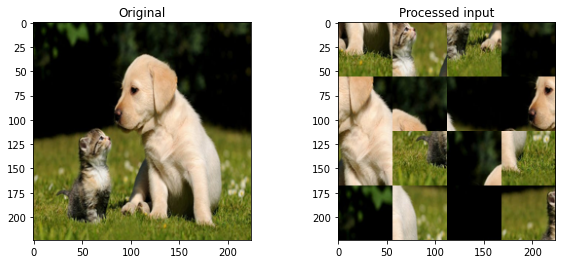

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.set_title('Original')
ax2.set_title('Processed input')
_ = ax1.imshow(img_origin)
_ = ax2.imshow(im)

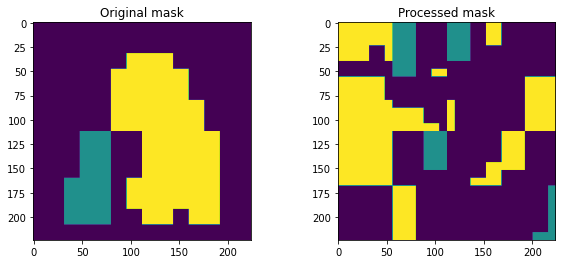

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

ax1.set_title('Original mask')
ax2.set_title('Processed mask')
_ = ax1.imshow(mask_full_keep_origin)
_ = ax2.imshow(mask_full_keep)

In [20]:
# def _attn_map(x, im):

logits, att_mat, hidden_states_layers  = model(x.unsqueeze(0))
att_mat = torch.stack(att_mat).squeeze(1)
att_mat.shape
# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1) # [n_layer, n_tokens, n_tokens]=[12, 197, 197]
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1)) # [n_tokens, n_tokens]=[197, 197]
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)
# print('aug_att_mat.size: ', aug_att_mat.size())

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())

joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1] # [n_tokens, n_tokens]
grid_size = int(np.sqrt(aug_att_mat.size(-1))) # grid_size
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy() # attentions from cls_token with patch token
mask = mask / mask.max() # [im_w, im_h, 1]
mask = Image.fromarray(mask)
print('mask.size: ', mask.size)
# mask = mask / mask.max()
mask = mask.resize(im.size) # [im_w, im_h, 1]
# result = (mask * im).astype("uint8")
# result = cv2.cvtColor((mask*255.0).astype("uint8"),cv2.COLOR_GRAY2RGB)
result = (np.asarray(mask)[..., None] * np.asarray(im)).astype("uint8")

mask.size:  (14, 14)


Prediction Label and Attention Map!

0.92545 : Labrador_retriever
0.02897 : golden_retriever
0.00527 : kuvasz
0.00177 : curly-coated_retriever
0.00161 : Border_collie


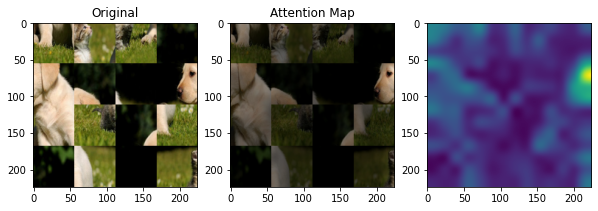

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 4))

ax1.set_title('Original')
ax2.set_title('Attention image')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)
_ = ax3.imshow(np.asarray(mask))

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

# <font color="blue">Visualize feature map</font>

In [22]:
from sklearn.manifold import TSNE

In [23]:
tsne_feature_layers = []
for hidden_states in hidden_states_layers:
#   input_tsne = torch.cat([hidden_states[0], cls_head_weight])
    input_tsne = hidden_states[0]
    tsne_feature = TSNE(n_components=2, perplexity=30.0, n_iter=1000, n_jobs=8, verbose=2).fit_transform(input_tsne.detach().numpy())
    tsne_feature_layers.append(tsne_feature)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 197 samples in 0.001s...
[t-SNE] Computed neighbors for 197 samples in 0.114s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 11.260246
[t-SNE] Computed conditional probabilities in 0.031s
[t-SNE] Iteration 50: error = 60.4421501, gradient norm = 0.5692588 (50 iterations in 0.087s)
[t-SNE] Iteration 100: error = 62.1137886, gradient norm = 0.5055794 (50 iterations in 0.073s)
[t-SNE] Iteration 150: error = 60.8161964, gradient norm = 0.5443111 (50 iterations in 0.071s)
[t-SNE] Iteration 200: error = 61.3290443, gradient norm = 0.5246913 (50 iterations in 0.073s)
[t-SNE] Iteration 250: error = 61.2253380, gradient norm = 0.5607566 (50 iterations in 0.069s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.225338
[t-SNE] Iteration 300: error = 0.8577684, gradient norm = 0.0065038 (50 iterations in 0.066s)
[t-SNE] Iteration 350: error = 0.5905878, gradient norm = 0.0058497 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 13.886091
[t-SNE] Computed conditional probabilities in 0.021s
[t-SNE] Iteration 50: error = 59.9330788, gradient norm = 0.5309970 (50 iterations in 0.082s)
[t-SNE] Iteration 100: error = 60.6432190, gradient norm = 0.5405281 (50 iterations in 0.075s)
[t-SNE] Iteration 150: error = 60.9959373, gradient norm = 0.5520974 (50 iterations in 0.078s)
[t-SNE] Iteration 200: error = 64.6206741, gradient norm = 0.4520770 (50 iterations in 0.072s)
[t-SNE] Iteration 250: error = 61.7309990, gradient norm = 0.5484835 (50 iterations in 0.080s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.730999
[t-SNE] Iteration 300: error = 0.7407688, gradient norm = 0.0081343 (50 iterations in 0.069s)
[t-SNE] Iteration 350: error = 0.5449200, gradient norm = 0.0040463 (50 iterations in 0.062s)
[t-SNE] Iteration 400: error = 0.5209144, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 17.289466
[t-SNE] Computed conditional probabilities in 0.021s
[t-SNE] Iteration 50: error = 61.3141327, gradient norm = 0.5127932 (50 iterations in 0.074s)
[t-SNE] Iteration 100: error = 61.0259705, gradient norm = 0.5251484 (50 iterations in 0.071s)
[t-SNE] Iteration 150: error = 63.0999374, gradient norm = 0.5053146 (50 iterations in 0.077s)
[t-SNE] Iteration 200: error = 63.1035614, gradient norm = 0.5020293 (50 iterations in 0.070s)
[t-SNE] Iteration 250: error = 62.9390793, gradient norm = 0.5253996 (50 iterations in 0.070s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.939079
[t-SNE] Iteration 300: error = 0.7012833, gradient norm = 0.0060455 (50 iterations in 0.069s)
[t-SNE] Iteration 350: error = 0.5230154, gradient norm = 0.0038767 (50 iterations in 0.063s)
[t-SNE] Iteration 400: error = 0.4945059, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 19.723168
[t-SNE] Computed conditional probabilities in 0.024s
[t-SNE] Iteration 50: error = 62.4815941, gradient norm = 0.5395651 (50 iterations in 0.079s)
[t-SNE] Iteration 100: error = 61.0060196, gradient norm = 0.5472103 (50 iterations in 0.071s)
[t-SNE] Iteration 150: error = 60.9073792, gradient norm = 0.5317039 (50 iterations in 0.072s)
[t-SNE] Iteration 200: error = 62.6550903, gradient norm = 0.5079336 (50 iterations in 0.080s)
[t-SNE] Iteration 250: error = 62.3986168, gradient norm = 0.4832056 (50 iterations in 0.071s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.398617
[t-SNE] Iteration 300: error = 0.6655293, gradient norm = 0.0071871 (50 iterations in 0.067s)
[t-SNE] Iteration 350: error = 0.4879526, gradient norm = 0.0039089 (50 iterations in 0.059s)
[t-SNE] Iteration 400: error = 0.4158203, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 21.625338
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 61.9945564, gradient norm = 0.4983361 (50 iterations in 0.080s)
[t-SNE] Iteration 100: error = 60.3023911, gradient norm = 0.5567943 (50 iterations in 0.077s)
[t-SNE] Iteration 150: error = 61.1650009, gradient norm = 0.5174341 (50 iterations in 0.078s)
[t-SNE] Iteration 200: error = 62.0512772, gradient norm = 0.5026329 (50 iterations in 0.070s)
[t-SNE] Iteration 250: error = 60.0516090, gradient norm = 0.5488367 (50 iterations in 0.073s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.051609
[t-SNE] Iteration 300: error = 0.6652354, gradient norm = 0.0057360 (50 iterations in 0.066s)
[t-SNE] Iteration 350: error = 0.4367214, gradient norm = 0.0039443 (50 iterations in 0.059s)
[t-SNE] Iteration 400: error = 0.4237180, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 23.923142
[t-SNE] Computed conditional probabilities in 0.021s
[t-SNE] Iteration 50: error = 63.5419998, gradient norm = 0.4446555 (50 iterations in 0.074s)
[t-SNE] Iteration 100: error = 59.9303055, gradient norm = 0.4950561 (50 iterations in 0.068s)
[t-SNE] Iteration 150: error = 61.2252884, gradient norm = 0.5195609 (50 iterations in 0.074s)
[t-SNE] Iteration 200: error = 59.3936729, gradient norm = 0.5058618 (50 iterations in 0.070s)
[t-SNE] Iteration 250: error = 59.9348183, gradient norm = 0.4925779 (50 iterations in 0.071s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.934818
[t-SNE] Iteration 300: error = 0.4938242, gradient norm = 0.0045378 (50 iterations in 0.067s)
[t-SNE] Iteration 350: error = 0.4319478, gradient norm = 0.0030280 (50 iterations in 0.059s)
[t-SNE] Iteration 400: error = 0.4093902, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Iteration 50: error = 59.4047508, gradient norm = 0.5288832 (50 iterations in 0.083s)
[t-SNE] Iteration 100: error = 60.5912094, gradient norm = 0.4821662 (50 iterations in 0.073s)
[t-SNE] Iteration 150: error = 59.8625870, gradient norm = 0.5524370 (50 iterations in 0.072s)
[t-SNE] Iteration 200: error = 60.5508766, gradient norm = 0.5209257 (50 iterations in 0.075s)
[t-SNE] Iteration 250: error = 59.8397179, gradient norm = 0.5605678 (50 iterations in 0.072s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.839718
[t-SNE] Iteration 300: error = 0.4480115, gradient norm = 0.0089375 (50 iterations in 0.073s)
[t-SNE] Iteration 350: error = 0.3498303, gradient norm = 0.0025627 (50 iterations in 0.060s)
[t-SNE] Iteration 400: error = 0.3330635, gradient norm = 0.0003553 (50 iterations in 0.059s)
[t-SNE] Iteration 450: error = 0.3328392, gradient norm = 0.0001667 (50 iterations in 0.058s)
[t-SNE] Iteration 500: error = 0.3326476, gradient norm = 0.0003695 (50 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.108s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 30.019906
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 58.8260384, gradient norm = 0.5651789 (50 iterations in 0.078s)
[t-SNE] Iteration 100: error = 60.9169121, gradient norm = 0.5170134 (50 iterations in 0.073s)
[t-SNE] Iteration 150: error = 59.6657181, gradient norm = 0.5282140 (50 iterations in 0.085s)
[t-SNE] Iteration 200: error = 59.4186554, gradient norm = 0.5058915 (50 iterations in 0.070s)
[t-SNE] Iteration 250: error = 58.1731949, gradient norm = 0.5428347 (50 iterations in 0.072s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.173195
[t-SNE] Iteration 300: error = 0.4390481, gradient norm = 0.0067454 (50 iterations in 0.064s)
[t-SNE] Iteration 350: error = 0.3791257, gradient norm = 0.0016819 (50 iterations in 0.060s)
[t-SNE] Iteration 400: error = 0.3487672, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 33.845452
[t-SNE] Computed conditional probabilities in 0.022s
[t-SNE] Iteration 50: error = 58.6888542, gradient norm = 0.5418780 (50 iterations in 0.077s)
[t-SNE] Iteration 100: error = 58.5962105, gradient norm = 0.5159201 (50 iterations in 0.068s)
[t-SNE] Iteration 150: error = 59.1033020, gradient norm = 0.5674236 (50 iterations in 0.074s)
[t-SNE] Iteration 200: error = 56.3041534, gradient norm = 0.5983884 (50 iterations in 0.085s)
[t-SNE] Iteration 250: error = 58.5091476, gradient norm = 0.5555276 (50 iterations in 0.070s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.509148
[t-SNE] Iteration 300: error = 0.3719706, gradient norm = 0.0059485 (50 iterations in 0.067s)
[t-SNE] Iteration 350: error = 0.3405998, gradient norm = 0.0021222 (50 iterations in 0.059s)
[t-SNE] Iteration 400: error = 0.3204064, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 39.143156
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 60.1407051, gradient norm = 0.4802371 (50 iterations in 0.075s)
[t-SNE] Iteration 100: error = 59.5275688, gradient norm = 0.5383089 (50 iterations in 0.070s)
[t-SNE] Iteration 150: error = 58.0732841, gradient norm = 0.5043100 (50 iterations in 0.076s)
[t-SNE] Iteration 200: error = 58.0363998, gradient norm = 0.5162286 (50 iterations in 0.077s)
[t-SNE] Iteration 250: error = 58.3805466, gradient norm = 0.5032426 (50 iterations in 0.135s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.380547
[t-SNE] Iteration 300: error = 0.3277583, gradient norm = 0.0029658 (50 iterations in 0.095s)
[t-SNE] Iteration 350: error = 0.3205401, gradient norm = 0.0003825 (50 iterations in 0.141s)
[t-SNE] Iteration 400: error = 0.3159417, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.106s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 48.333048
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 59.3938828, gradient norm = 0.5064493 (50 iterations in 0.076s)
[t-SNE] Iteration 100: error = 58.9232330, gradient norm = 0.5133931 (50 iterations in 0.069s)
[t-SNE] Iteration 150: error = 56.7995338, gradient norm = 0.5407017 (50 iterations in 0.070s)
[t-SNE] Iteration 200: error = 57.4657211, gradient norm = 0.5352065 (50 iterations in 0.067s)
[t-SNE] Iteration 250: error = 57.9625740, gradient norm = 0.5413793 (50 iterations in 0.066s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.962574
[t-SNE] Iteration 300: error = 0.3350083, gradient norm = 0.0062739 (50 iterations in 0.061s)
[t-SNE] Iteration 350: error = 0.2837706, gradient norm = 0.0016134 (50 iterations in 0.063s)
[t-SNE] Iteration 400: error = 0.2735157, gradient norm =

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 197 samples in 0.109s...
[t-SNE] Computed conditional probabilities for sample 197 / 197
[t-SNE] Mean sigma: 52.552815
[t-SNE] Computed conditional probabilities in 0.032s
[t-SNE] Iteration 50: error = 58.8054008, gradient norm = 0.5035192 (50 iterations in 0.069s)
[t-SNE] Iteration 100: error = 59.5405998, gradient norm = 0.5071228 (50 iterations in 0.068s)
[t-SNE] Iteration 150: error = 57.3616180, gradient norm = 0.5505912 (50 iterations in 0.071s)
[t-SNE] Iteration 200: error = 58.5529442, gradient norm = 0.5190560 (50 iterations in 0.067s)
[t-SNE] Iteration 250: error = 58.2933044, gradient norm = 0.5446867 (50 iterations in 0.067s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.293304
[t-SNE] Iteration 300: error = 0.3288431, gradient norm = 0.0057842 (50 iterations in 0.065s)
[t-SNE] Iteration 350: error = 0.3006848, gradient norm = 0.0006255 (50 iterations in 0.072s)
[t-SNE] Iteration 400: error = 0.2944317, gradient norm =

# <font color="blue">Hand segmentation process</font>

In [24]:
# segmentation_mask = targets['masks'].type(torch.float)
mask_to_idx = []
num_object = len(np.unique(mask_full_keep)) - 1
mask_resize = np.zeros((14,14))
for i in range(14):
    for j in range(14):
#         print(i*16,(i+1)*16, j*16,(j+1)*16)
        unique_m, count_m = np.unique(mask_full_keep[i*16:(i+1)*16, j*16:(j+1)*16], return_counts=True)
        mask_resize[i, j] = unique_m[np.argmax(count_m)]
#         print(unique_m, count_m, unique_m[np.argmax(count_m)])

mask_resize = mask_resize.reshape(-1).astype(np.int64)
# print(mask_resize.max(), mask_resize.min())
for idx_object in range(num_object):
    m_instance = np.argwhere(mask_resize == idx_object+1)
    mask_to_idx.append(m_instance)
total_mask = np.where(mask_resize >= 1)
none_object_idx = np.where(mask_resize == 0)
mask_to_idx.append(none_object_idx)

Text(0.5, 0, 'Attention score last layer')

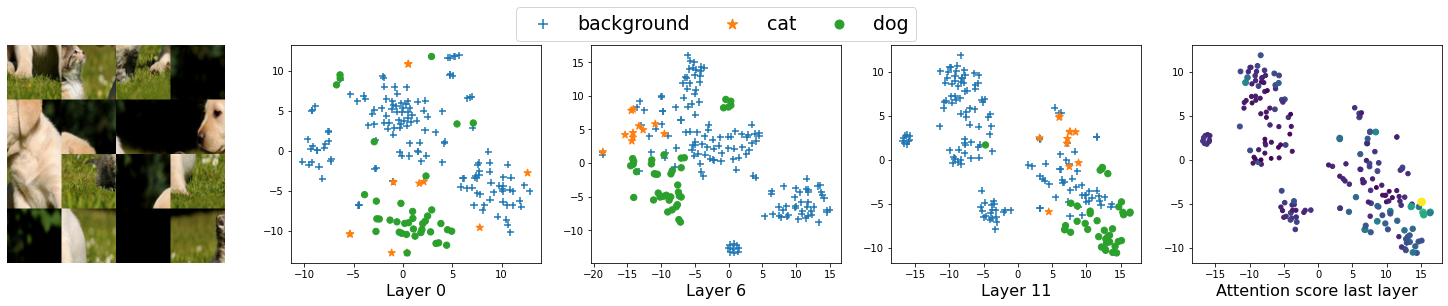

In [25]:
# lvl_list = [0, 3, 6, 9, 11]
# lvl_list = [0, 4, 8, 11]
lvl_list = [0, 6, 11]
fg, ax = plt.subplots(1, len(lvl_list)+2, figsize=(26, 4))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
#     att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
    att_lvl[idx_non_obj] = 1
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*50, marker='+', label="background")
#     lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
    lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
#     s_scale=[19000, 9000, 9000, 15000, 9000]
    s_scale=[60, 40, 60, 60, 40]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
#         att_lvl[idx_object] = attention_join[1:][idx_object]
        att_lvl[idx_object] = 1
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-1.5, 1.02, 1.6, .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0., prop={"size":19}, markerscale=2.)
#     lvl+= 1
    idx_plot += 1
ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=attention_join[1:]*5000, c=attention_join[1:])
ax[idx_plot].set_xlabel("Attention score last layer", fontsize=16)
# plt.savefig("tsne_dog_cat_shuffle_2.png", bbox_inches='tight', pad_inches=0)

Text(0.5, 0, 'Attention score last layer')

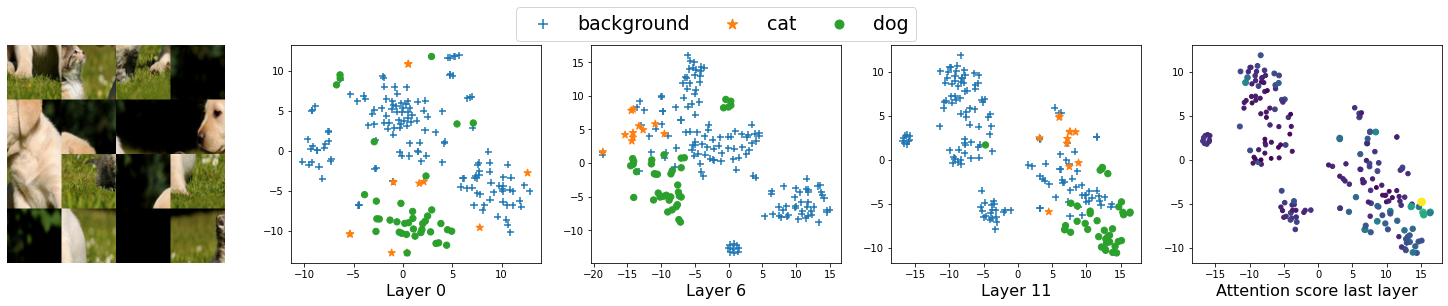

In [26]:
# lvl_list = [0, 3, 6, 9, 11]
# lvl_list = [0, 4, 8, 11]
lvl_list = [0, 6, 11]
fg, ax = plt.subplots(1, len(lvl_list)+2, figsize=(26, 4))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
#     att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
    att_lvl[idx_non_obj] = 1
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*50, marker='+', label="background")
#     lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
    lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
#     s_scale=[19000, 9000, 9000, 15000, 9000]
    s_scale=[60, 40, 60, 60, 40]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
#         att_lvl[idx_object] = attention_join[1:][idx_object]
        att_lvl[idx_object] = 1
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-1.5, 1.02, 1.6, .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0., prop={"size":19}, markerscale=2.)
#     lvl+= 1
    idx_plot += 1
ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=attention_join[1:]*5000, c=attention_join[1:])
ax[idx_plot].set_xlabel("Attention score last layer", fontsize=16)
# plt.savefig("tsne_dog_cat.png", bbox_inches='tight', pad_inches=0)

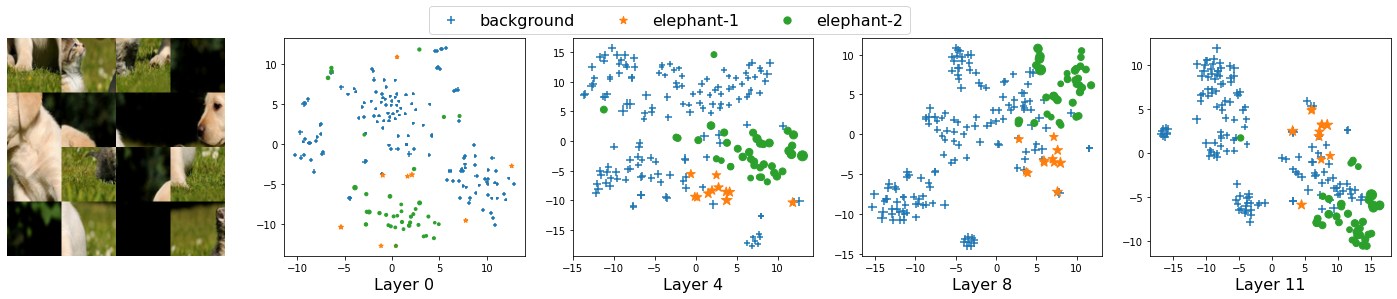

In [27]:
# lvl_list = [0, 3, 6, 9, 11]
lvl_list = [0, 4, 8, 11]
fg, ax = plt.subplots(1, len(lvl_list)+1, figsize=(25, len(lvl_list)))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
    att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
#     lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
    lb = ['elephant-1', "elephant-2", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
    s_scale=[19000, 9000, 9000, 15000, 9000]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
        att_lvl[idx_object] = attention_join[1:][idx_object]
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-3, 1.02, 2., .102), loc='lower left',
                      ncol=6, mode="expand", borderaxespad=0., prop={"size":16})
#     lvl+= 1
    idx_plot += 1
# plt.savefig("tsne_2_elephant_shuffle.png", bbox_inches='tight', pad_inches=0)

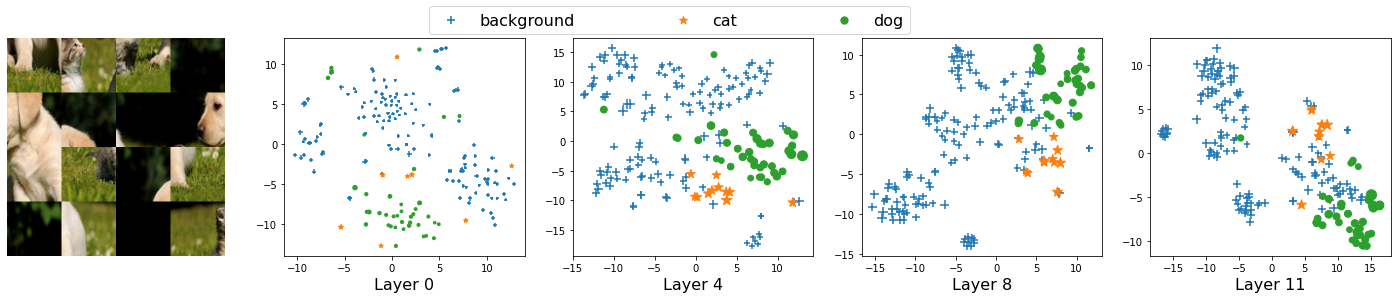

In [28]:
# lvl_list = [0, 3, 6, 9, 11]
lvl_list = [0, 4, 8, 11]
fg, ax = plt.subplots(1, len(lvl_list)+1, figsize=(25, len(lvl_list)))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
    att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
#     lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
    lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
    s_scale=[19000, 9000, 9000, 15000, 9000]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
        att_lvl[idx_object] = attention_join[1:][idx_object]
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-3, 1.02, 2., .102), loc='lower left',
                      ncol=3, mode="expand", borderaxespad=0., prop={"size":16})
#     lvl+= 1
    idx_plot += 1
# plt.savefig("tsne_dog_cat_shuffle_2.png", bbox_inches='tight', pad_inches=0)

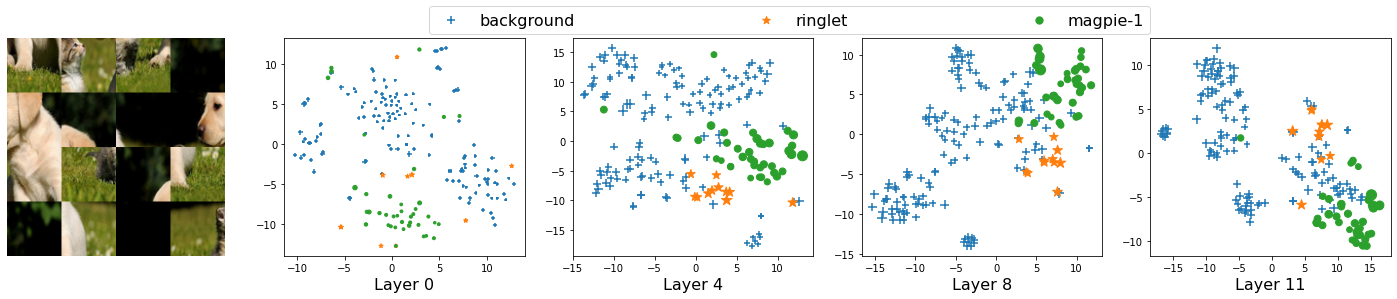

In [29]:
# lvl_list = [0, 3, 6, 9, 11]
lvl_list = [0, 4, 8, 11]
fg, ax = plt.subplots(1, len(lvl_list)+1, figsize=(25, len(lvl_list)))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
    att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
    lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
#     lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
    s_scale=[19000, 9000, 9000, 15000, 9000]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
        att_lvl[idx_object] = attention_join[1:][idx_object]
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-3., 1.02, 3, .102), loc='lower left',
                      ncol=6, mode="expand", borderaxespad=0., prop={"size":16})
#     lvl+= 1
    idx_plot += 1
# plt.savefig("tsne_multi_objects_shuffle.png", bbox_inches='tight', pad_inches=0)

Text(0.5, 0, 'Attention score last layer')

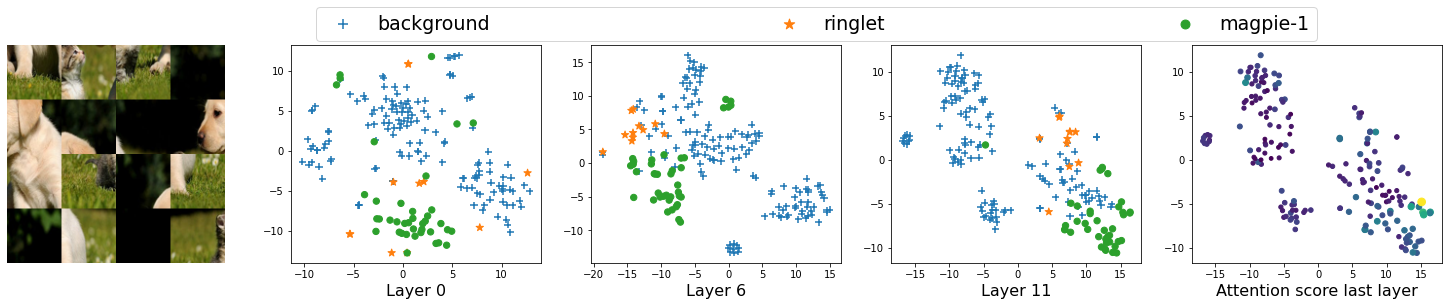

In [30]:
# lvl_list = [0, 3, 6, 9, 11]
# lvl_list = [0, 4, 8, 11]
lvl_list = [0, 6, 11]
fg, ax = plt.subplots(1, len(lvl_list)+2, figsize=(26, 4))
# fg, ax = plt.subplots(2, 2, figsize=(10, 10))
# fg.suptitle('TSNE, output_layer_i')
attention_join_last = joint_attentions[-1][0]  # score for cls_token to every patch_token
# attention_score = (attention_score - attention_score.min())/(attention_score.max() - attention_score.min())
attention_join_last = attention_join_last.detach().numpy()
cls_size = 14*14+1
lvl = 0
# targets['boxes'][0]
# bb_idx = (target_box_valid * 14).type(torch.int)
# bb_idx = (targets['boxes'][0] * 14).type(torch.int)

all_idx = np.arange(14*14).reshape(14, 14)
ax[0].imshow(im)
ax[0].set_axis_off()
idx_plot = 1
for lvl in lvl_list:
    tsne_feature = tsne_feature_layers[lvl][:cls_size]
    # aug_att_mat
    # attention_score = joint_attentions[lvl][1:, 0] # score for each patch_token to cls_token
    attention_join = joint_attentions[lvl][0]  # score for cls_token to every patch_token
#     attention_join = (attention_join - attention_join.min())/(attention_join.max() - attention_join.min())
    attention_join = attention_join.detach().numpy()
    
    idx_non_obj = mask_to_idx[-1]
    att_lvl = np.zeros_like(attention_join[1:])
#     att_lvl[idx_non_obj] = attention_join[1:][idx_non_obj]
    att_lvl[idx_non_obj] = 1
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000, c=attention_join[1:],marker='+', label="background")
#     ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*15000,marker='+', label="background")
    ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=att_lvl*50, marker='+', label="background")
    lb = ['ringlet', "magpie-1", "magpie-2", 'ox', 'assault_rifle']
#     lb = ['cat', "dog", "magpie-2", 'ox', 'assault_rifle']
    marker_lst = ["*", "o", "v", "x", "D", "*"]
#     s_scale=[19000, 9000, 9000, 15000, 9000]
    s_scale=[60, 40, 60, 60, 40]
#     s_scale=[110, 50, 110]
    for idx_ob, idx_object in enumerate(mask_to_idx[:-1]):
        att_lvl = np.zeros_like(attention_join[1:])
#         att_lvl[idx_object] = attention_join[1:][idx_object]
        att_lvl[idx_object] = 1
#         ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], c=attention_join[1:], s=att_lvl*s_scale[idx_ob])
        ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], marker=marker_lst[idx_ob], label=lb[idx_ob], s=att_lvl*s_scale[idx_ob])
#         ax[idx_plot, 1].scatter(tsne_feature[1:, 0][idx_object], tsne_feature[1:, 1][idx_object], marker=marker_lst[idx_ob], label=lb[idx_ob], s=attention_join[1:][idx_object]*10000)
    
    ax[idx_plot].set_xlabel("Layer {}".format(lvl), fontsize=16)
    if idx_plot == len(lvl_list):
        ax[idx_plot].legend(bbox_to_anchor=(-2.3, 1.02, 4, .102), loc='lower left',
                      ncol=6, mode="expand", borderaxespad=0., prop={"size":19}, markerscale=2.)
#     lvl+= 1
    idx_plot += 1
ax[idx_plot].scatter(tsne_feature[1:, 0], tsne_feature[1:, 1], s=attention_join[1:]*5000, c=attention_join[1:])
ax[idx_plot].set_xlabel("Attention score last layer", fontsize=16)
# plt.savefig("tsne_multi_objects.png", bbox_inches='tight', pad_inches=0)